## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data wrangling
import pandas as pd
import numpy as np

#keras layers & model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation
from keras.layers import MaxPooling2D, BatchNormalization

#One Hot Encoding
from keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib

from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)

from sklearn.model_selection import train_test_split
import random
import os
from random import randint
import random as rdn
#from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

from tensorflow.keras.preprocessing.image import array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array



#from keras.applications import resnet50
#from keras.applications.resnet50 import preprocess_input
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

zip_files = ['test1', 'train']

zf = zipfile.ZipFile("/content/dogs-vs-cats.zip","r")
zf.extractall()
zf.close()


In [ ]:

zf = zipfile.ZipFile("test1.zip")
zf.extractall('/content')
zf.close()


In [ ]:

zf = zipfile.ZipFile("/content/train.zip","r")
zf.extractall('/content')
zf.close()


In [ ]:
filenames = os.listdir("/content/train")
labels = []
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': labels
})

## Preprocessing

In [ ]:
df.head(3)

filename  category
0   dog.2710.jpg         1
1   cat.5646.jpg         0
2  dog.11527.jpg         1

In [ ]:
df.isnull().sum()

filename    0
category    0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


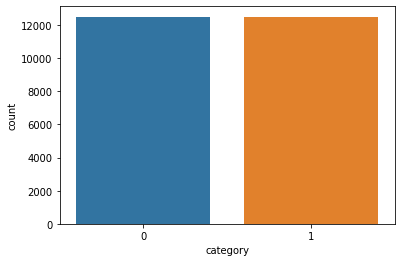

In [ ]:
sns.countplot(df['category'])

In [ ]:
df['category'].value_counts(dropna= False)

1    12500
0    12500
Name: category, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   category  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


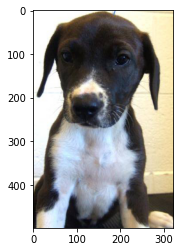

In [ ]:
import matplotlib.pyplot as plt

test_img = random.choice(filenames)

image = load_img("/content/train/"+test_img)


plt.imshow(image)

#matplotlib.pyplot.imshow(image)

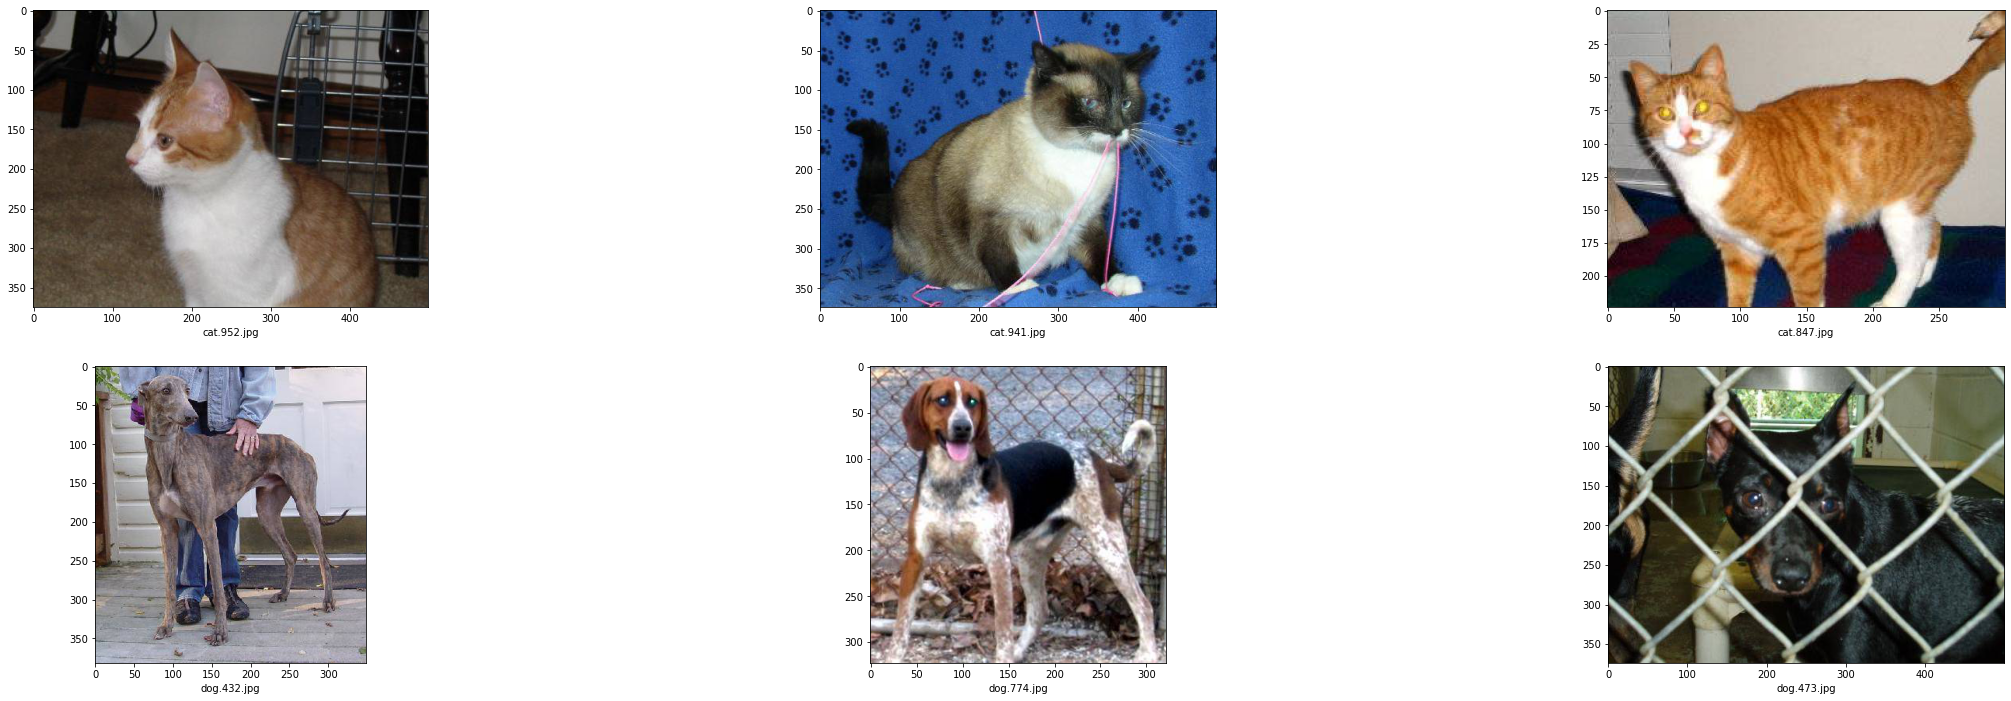

In [ ]:
train_path = 'train/'

n_pictures = 6 # number of pictures to be shown
columns = int(n_pictures / 2)
rows = 2
plt.figure(figsize=(40, 12))
for i in range(n_pictures):
    num = i + 1
    ax = plt.subplot(rows, columns, i + 1)
    if i < columns:
        image_name = 'cat.' + str(rdn.randint(1, 1000)) + '.jpg'
    else: 
        image_name = 'dog.' + str(rdn.randint(1, 1000)) + '.jpg'
    plt.xlabel(image_name)    
    plt.imshow(load_img(train_path + image_name)) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
total_train = train_df.shape[0]

validate_df = validate_df.reset_index(drop=True)
total_validate = validate_df.shape[0]
#train_df.head()

print(len(train_df), len(validate_df))

20000 5000


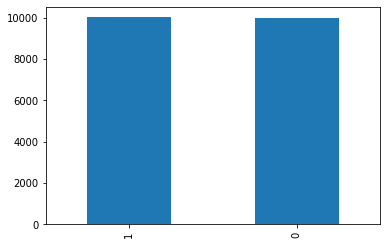

In [ ]:
train_df['category'].value_counts().plot.bar()

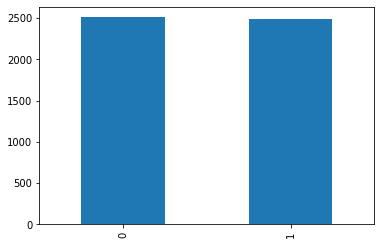

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
# set the dimensions to which we will convert the images
img_width, img_height = 128, 128
target_size = (img_width, img_height)
batch_size = 15
#rescale=1.0/255


## configure the train data generator


In [ ]:
# FAST_RUN = False
# IMAGE_WIDTH=128
# IMAGE_HEIGHT=128
# IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# IMAGE_CHANNELS=3

# batch_size=15

In [ ]:
 train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    brightness_range=[0.2,1.2],
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path,
    shear_range=0.2, #
    zoom_range=0.2, #
    horizontal_flip=True, #
    
    shuffle=True, # shuffle the image data
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='raw')



Found 20000 validated image filenames.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:930: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn(


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path,
    shear_range=0.2, #
    zoom_range=0.2, #
    horizontal_flip=True, # 
    shuffle=True, # shuffle the image data
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='raw'
)

Found 5000 validated image filenames.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=target_size,
    class_mode='raw'
)

Found 1 validated image filenames.


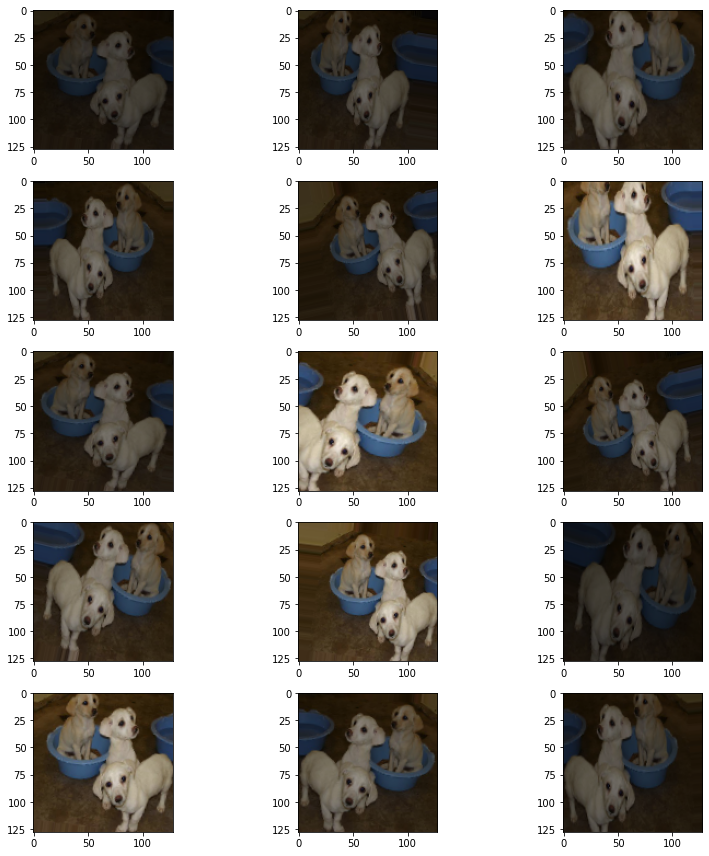

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

##Model

In [ ]:
input_shape = (img_width, img_height, 3)
print(input_shape)

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3),  strides=(1, 1),activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(2, activation='sigmoid')) # 2 because we have cat and dog classes




(128, 128, 3)


In [ ]:
# compile the model and print its architecture
opt = SGD(lr=0.001, momentum=0.9)
history = model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)      

## Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
earlystop = EarlyStopping(patience=10, monitor='val_accuracy')

In [ ]:
filepath = 'weights-loss-{epoch:02d}-{val_loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                save_best_only=False, save_freq= "epoch",  
                save_weights_only=False, mode='auto')




Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction,checkpoint]

## Fit Model

In [ ]:
model.load_weights('weights-loss-10-0.35.hdf5')

In [ ]:
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    generator = train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks
)

Epoch 1/10


<ipython-input-127-fa22ac0e4732>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.7961
Epoch 1: saving model to weights-loss-01-0.63.hdf5
1333/1333 [==============================] - 144s 107ms/step - loss: 0.4364 - accuracy: 0.7961 - val_loss: 0.6265 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.7996
Epoch 2: saving model to weights-loss-02-0.36.hdf5
1333/1333 [==============================] - 144s 108ms/step - loss: 0.4299 - accuracy: 0.7996 - val_loss: 0.3622 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8051
Epoch 3: saving model to weights-loss-03-0.34.hdf5
1333/1333 [==============================] - 143s 107ms/step - loss: 0.4234 - accuracy: 0.8051 - val_loss: 0.3411 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8046
Epoch 4: saving 

In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-129-5bf9ded073bc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.863664  ;  loss = 0.320336 


##Save Model

In [ ]:
#Safe the weights
model.save_weights('cats-and-dogs-weights-v1.h5')

In [ ]:
# load Model
#model.load_weights('cats-and-dogs-weights-v1.h5')

In [ ]:
#loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.863664  ;  loss = 0.320336 


##Visualise Training

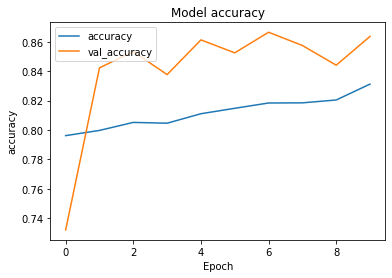

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'], loc="upper left")
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()


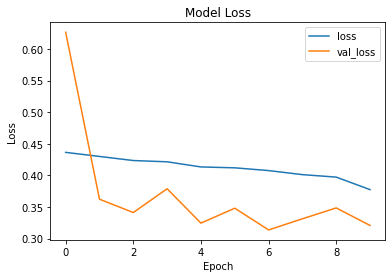

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

##Accuracy


In [ ]:
y_val = validate_df['category']

y_pred = model.predict_generator(validation_generator)

<ipython-input-136-74ac3e02f5ad>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_generator)


In [ ]:
y_val

0       1
1       1
2       0
3       1
4       0
       ..
4995    1
4996    1
4997    1
4998    0
4999    1
Name: category, Length: 5000, dtype: int64

In [ ]:
y_pred

array([[0.6112647 , 0.35408035],
       [0.9070139 , 0.07033743],
       [0.07971104, 0.7226168 ],
       ...,
       [0.7832502 , 0.19613756],
       [0.68697244, 0.06258239],
       [0.25823948, 0.87781525]], dtype=float32)

In [ ]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [ ]:
y_final.size

10000

In [ ]:
rounded_y_final = np.argmax(y_final, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

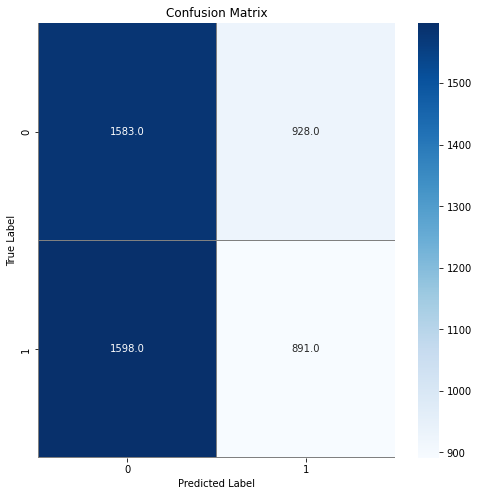

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_val, rounded_y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_val, rounded_y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.50      0.63      0.56      2511
           1       0.49      0.36      0.41      2489

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.48      5000
weighted avg       0.49      0.49      0.49      5000



##Testing Data

In [ ]:
filenames = os.listdir("/content/test1")

test_df = pd.DataFrame({
    'filename': filenames
})
nb_samples = test_df.shape[0]

Test Generator

In [ ]:
test_path = "/content/test1"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    test_path, 
    shuffle= False, # shuffle the image data
    x_col='filename', 
    y_col= None,
    #classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    #color_mode="rgb",
    class_mode= None
)


Found 12500 validated image filenames.


##PREDICT

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-148-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
test_df['predicted'] = np.argmax(predict, axis=-1)

In [ ]:
test_df.head()

filename  predicted
0  12175.jpg          0
1   1457.jpg          1
2   7185.jpg          0
3   3688.jpg          1
4   5842.jpg          0

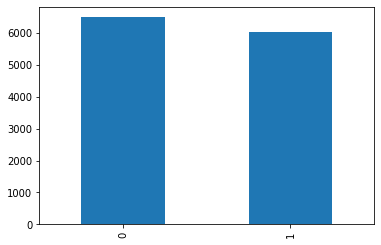

In [ ]:
test_df['predicted'].value_counts().plot.bar()

In [ ]:
test_df['predicted'] = test_df['predicted'].replace({ 1: 'dog', 0: 'cat'})

In [ ]:
test_df.head()

filename predicted
0  12175.jpg       cat
1   1457.jpg       dog
2   7185.jpg       cat
3   3688.jpg       dog
4   5842.jpg       cat

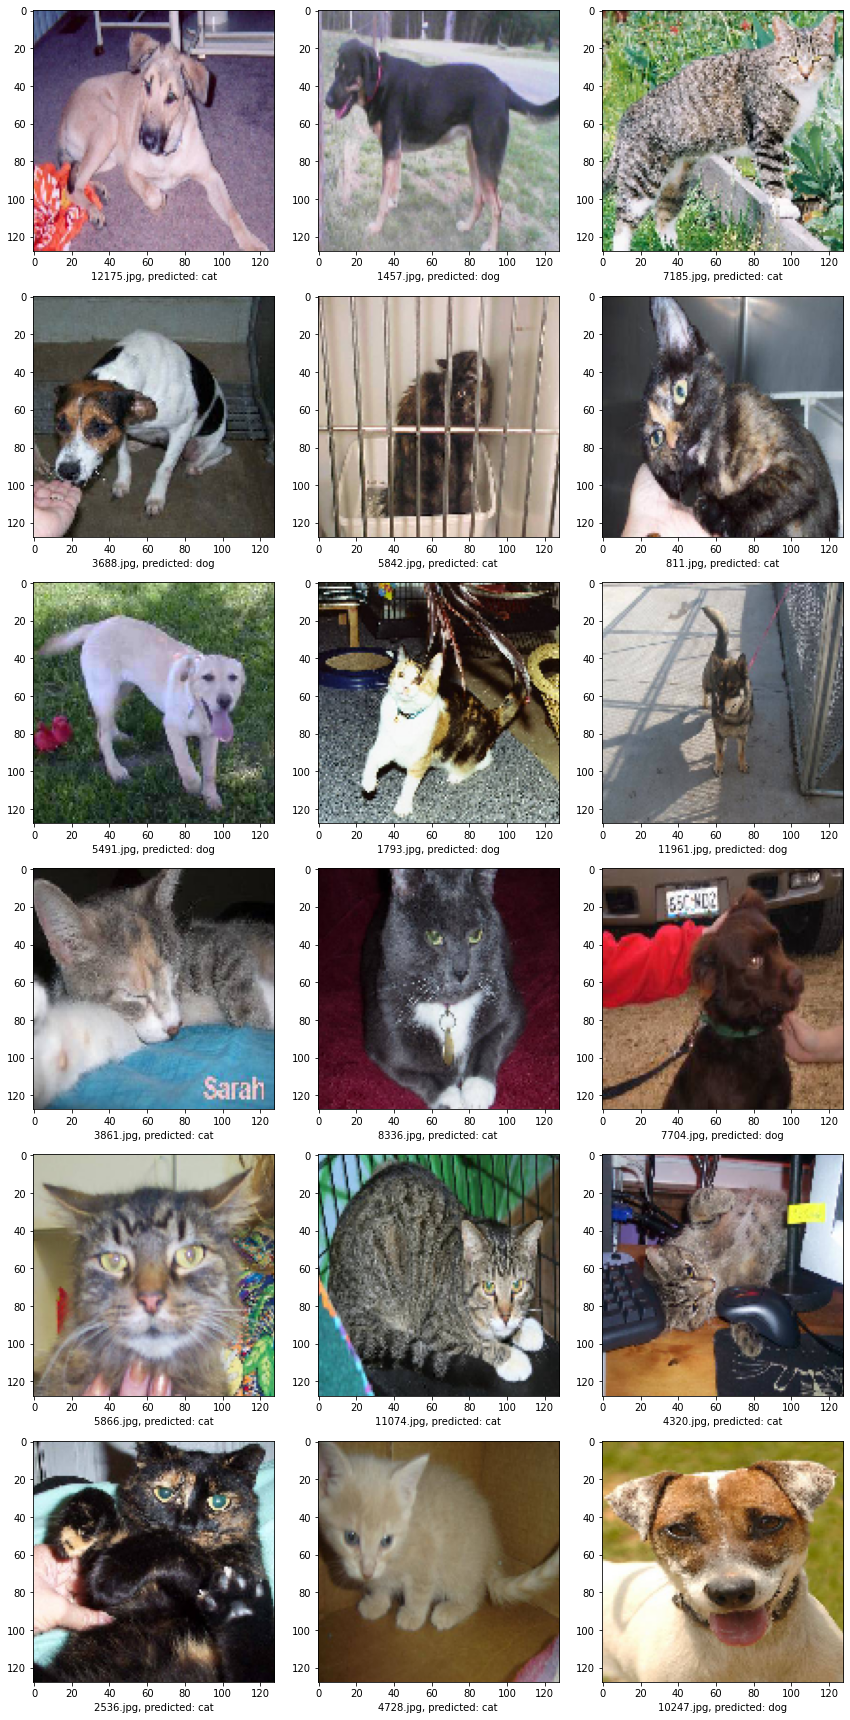

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    predicted = row['predicted']
    img = load_img("/content/test1/"+filename, target_size= target_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f'{filename}, predicted: {predicted}')
plt.tight_layout()
plt.show()